In [1]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import matplotlib as mpl
from mne.stats import permutation_cluster_test
from mne.stats import permutation_cluster_1samp_test

from IPython.display import clear_output

sns.set(style="darkgrid")
sns.set(font_scale=1.5)

data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']


trial_len = 2
remove_first = 0.5 #seconds

save_path = data_path + '/data/coherence'

info = mne.io.read_raw_fif((save_path+'-info'),preload=True)
save_path = data_path + '/data/1-12Hz_frequency_bands_in2hzStep_coherence/coherence-trialLen-'+str(trial_len)+'-removedFirst-'+str(remove_first)+'s'


Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


# reading the coherence


In [2]:
a=[]
for s in subject_name:
    a.append(pd.read_pickle(save_path+'-'+s))

data = pd.concat((a),axis=0)
data['Delay']=data['Delay'] - 0.5
data['Delay']=data['Delay'].round(decimals=1)

fr = data.Freq.unique()
print(fr)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)

data.head(10)

['fr 1 - 3Hz' 'fr 2 - 4Hz' 'fr 3 - 5Hz' 'fr 4 - 6Hz' 'fr 5 - 7Hz'
 'fr 6 - 8Hz' 'fr 7 - 9Hz' 'fr 8 - 10Hz' 'fr 9 - 11Hz' 'fr 10 - 12Hz']


Data  \
Feature Freq       Condition Delay Subject                                                        
TBCD    fr 1 - 3Hz All       -0.5  Alice      [0.033626582311162945, 0.034497697001947845, 0...   
                                   Andrea     [0.06383926200123333, 0.06341947417211743, 0.0...   
                                   Daniel     [0.10159732515014652, 0.08483773598828487, 0.0...   
                                   Elena      [0.03330132549171278, 0.029116455151553696, 0....   
                                   Elenora    [0.026748670820600343, 0.03354287806092756, 0....   
                                   Elisa      [0.03486282579365345, 0.021433742824380757, 0....   
                                   Federica   [0.04973559315451472, 0.04086771909279906, 0.0...   
                                   Francesca  [0.03553686939641644, 0.0171126356429377, 0.00...   
                                   Giada      [0.03836723365391403, 0.035028023481639144, 0....   
                                   Gianluca1  [0.030962435061166967, 0.025311440744588947, 0...   

                                              noTrials  Coherence  
Feature Freq       Condition Delay Subject                         
TBCD    fr 1 - 3Hz All       -0.5  Alice           124   0.032136  
                                   Andrea          121   0.045153  
                                   Daniel          122   0.074797  
                                   Elena           121   0.043596  
                                   Elenora         122   0.027884  
                                   Elisa           114   0.041116  
                                   Federica        119   0.027506  
                                   Francesca       119   0.045296  
                                   Giada           121   0.042186  
                                   Gianluca1       120   0.034675

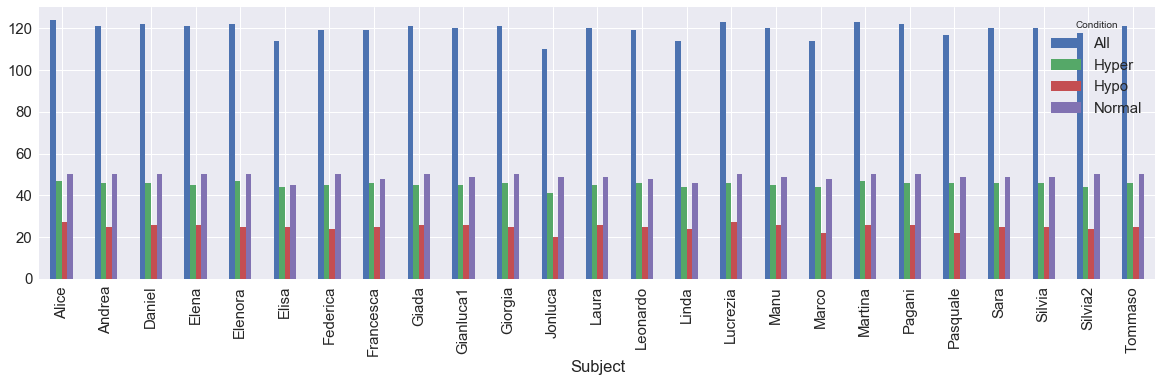

In [3]:
condition = ['Hyper','Normal','Hypo','All']
a=pd.DataFrame(data.loc['envelop',fr[0],condition,0,subject_name])
a=a.groupby(['Subject','Condition']).sum()['noTrials'].unstack().plot(kind='bar',figsize=(20,5),grid=True)

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = [ 'fr 1 - 3Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

a = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value="Coherence",color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Coherence')

In [6]:
def get_coherence_value_delay(data,name,subject_name,delay,condition): 
    D = []
    D_std = []
    for d in delay:
        A = []
        B=[]
        for c in condition:
            a  = data.loc[name[0],name[1],c,d,subject_name].as_matrix().mean(axis=0)
            A.append(a[0].mean())
            B.append(a[0].std())

        D.append(A)
        D_std.append(B)
        
    D=np.asarray(D)
    D_std=np.asarray(D_std)
    
    frames=[]
    frames1=[]
    for c in range(0,len(condition)):
        frames.append(pd.DataFrame({condition[c]:D[:,c]}))
        frames1.append(pd.DataFrame({condition[c]:D_std[:,c]}))
        
    df=pd.concat((frames),axis=1)
    df.index = delay
    df.index.name = 'Delay'
    
    df_std=pd.concat((frames1),axis=1)
    df_std.index = delay
    df_std.index.name = 'Delay'
    return df,df_std

def get_coherence_value(data,name,subject_name,d,condition):
    x=[]
    for i in condition:
        a  = data.loc[name[0],name[1],i,d,subject_name].as_matrix().mean(axis=0)
        x.append(a[0])

    return x

def plot_coherence(data,vmax,vmin,axes,name,info): 
    im = mne.viz.plot_topomap(data, info.info, axes=axes, show=False,vmin=vmin,vmax=vmax)
    axes.set(title=name)
    return im

def plot_coherence_preprocess(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(condition),figsize=(10,4))
    for i in range(0,len(condition)):
        im = plot_coherence(x[i],vmax,vmin,axes[i],condition[i],info)

    fig.suptitle(name[0]+'-Delay-'+ str(delay)+ '-'+name[1])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.04, 0.3])
    fig.colorbar(im[0], cax=cbar_ax)
    fig.show()
    
def plot_coherence_preprocess_delay(x,name,condition,delay,info):
    vmax=np.amax(np.concatenate(x, axis=0))
    vmin=np.amin(np.concatenate(x, axis=0))

    fig, axes = plt.subplots(1, len(delay),figsize=(20,6))
    for i in range(0,len(delay)):
        im = plot_coherence(x[i][0],vmax,vmin,axes[i],delay[i],info)

    fig.suptitle(name[0]+ ' - '+name[1]+' - '+ str(condition[0]),y=0.7)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.50, 0.01, 0.15])
    fig.colorbar(im[0], cax=cbar_ax)
    #fig.show()
    return fig
    
def get_coherence_value1(data,Feature,Freq,condition,Delay,subject_name):
    x=[]
    for f in Feature:
        for fr in Freq:
            for c in condition:
                for d in Delay:
                    a  = data.loc[f,fr,c,d,subject_name].as_matrix().mean(axis=0)
                    x.append(a[0])
    return x

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']
freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
 'fr 9 - 11Hz', 'fr 10 - 12Hz']
freq_band = ['fr 1 - 3Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

A = get_coherence_value1(data,extra_channels,freq_band,condition,delay,subject_name)
vmax=np.amax(np.concatenate(A, axis=0))
vmin=np.amin(np.concatenate(A, axis=0))

a = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Data']
a = pd.DataFrame(a.reset_index())

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].mean()    
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax)

fg = sns.FacetGrid(a, col='Delay', row = 'Condition',margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
b.fig.subplots_adjust(top=0.9)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(extra_channels[0]+' - '+freq_band[0])

cbar_ax = b.fig.add_axes([0.82,0.10,0.01,0.75])

#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax)

# permutation staticstics on delay time points (should be done on two features and 1 freq at a time)

In [ ]:
def run_permutation_test(x,y,numSamples):
    pooled = np.hstack([x,y])
    d0 = x.mean() - y.mean()
    d = np.zeros((numSamples,))
    for k in range(numSamples):
        np.random.shuffle(pooled)
        starZ = pooled[:len(x)]
        starY = pooled[-len(y):]    
        d[k] = starZ.mean() - starY.mean()
        
    p = len(np.where( d >= d0 )[0])
    p = p / float(numSamples)
    return p

def get_P_value(data,extra_channels,freq_band,condition,delay,numSamples):
    A = []
    
    for c in condition:
        for fr in freq_band:        
            for d in delay:
                group1 = data.loc[extra_channels[0],fr,c,d,subject_name]['Coherence']
                group2 = data.loc[extra_channels[1],fr,c,d,subject_name]['Coherence']
                a = run_permutation_test(group1.get_values(),group2.get_values(),numSamples)
                p = pd.DataFrame({'Delay':d,'Freq':fr,'Condition':c,'FeatureTest':[extra_channels],'p-value':a})
                A.append(p)
                
    P = pd.concat((A),axis=0)
    return P

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = [ 'fr 4 - 6Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']

delay = np.arange(-5,6) / 10

a = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

# permutation stat
numSamples = 10000
P = get_P_value(data,extra_channels,freq_band,condition,delay,numSamples)
x = P[P['p-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.055,len(x))

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value="Coherence",color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Coherence')
# mark the signifiancant point
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')

# staticstics on the delay

In [ ]:

#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']
freq_band = [ 'fr 1 - 3Hz']
condition = ['All']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop']
delay = np.arange(-5,6) / 10

numSamples = 1000

frames=[]
for c in condition:
        for fr in freq_band:    
            for s in subject_name:
                a = data.loc[extra_channels,freq_band,condition,delay,s]['Coherence'].get_values()   
                b = a.copy()
                X = np.zeros((len(delay),numSamples))
                for i in range(numSamples):
                    np.random.shuffle(a)
                    X[:,i] = a
                x = X.mean(axis=1)    

                aa = pd.DataFrame({'Subject':s,'Delay':delay,'Feature':'Surrogate','Freq':fr,'Condition':c,'Coherence':x})
                frames.append(aa)    
                aa = pd.DataFrame({'Subject':s,'Delay':delay,'Feature':'Original','Freq':fr,'Condition':c,'Coherence':b})
                frames.append(aa)    
    
data_chanceCoh = pd.concat((frames),axis=0)
data_chanceCoh.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_chanceCoh.sort_index(inplace=True)


# permutation stat between surrogate and original
numSamples = 1000
P = get_P_value(data_chanceCoh,['Original','Surrogate'],freq_band,condition,delay,numSamples)
x = P[P['p-value'] <= 0.05]['Delay'].get_values()
y = np.repeat(0.04,len(x))

#plot
data_chanceCoh = pd.DataFrame(data_chanceCoh.reset_index())
g = sns.FacetGrid(data_chanceCoh, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value="Coherence",color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels(extra_channels[0]+'-Coherence')
# mark the signifiancant point
x = plt.plot(x,y, marker='*', color='k',markersize=10,linestyle='')

# cluster permutation on original - surrogate coherence  

In [4]:
# read surrogate coherence
save_path = data_path + '/data\SurrogateCoherence/SurrogateCoherence-trialLen-'+str(trial_len)+'-removedFirst-'+str(remove_first)+'s'

a=[]
for s in subject_name:
    a.append(pd.read_pickle(save_path+'-'+s))

data_surrogate = pd.concat((a),axis=0)
data_surrogate['Delay']=data_surrogate['Delay'] - 0.5
data_surrogate['Delay']=data_surrogate['Delay'].round(decimals=1)

fr = data_surrogate.Freq.unique()
print(fr)


a  = data_surrogate['Surrogate'].apply(lambda x: np.mean(x))
data_surrogate['Coherence'] = pd.Series(a, index=data_surrogate.index)
data_surrogate = data_surrogate.rename(index=str, columns={"Surrogate": "Data"})
data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)
data_surrogate.sample(10)

['fr 1 - 3Hz' 'fr 4 - 6Hz']


Data  \
Feature       Freq       Condition Delay Subject                                                        
lipProtrusion fr 1 - 3Hz All        0.0  Alice      [0.03417434214701315, 0.03453425508986417, 0.0...   
envelop       fr 1 - 3Hz All       -0.3  Manu       [0.02954510278311159, 0.03106420269390255, 0.0...   
lipaparature  fr 1 - 3Hz All        0.1  Gianluca1  [0.03050661049906385, 0.0314165356072871, 0.02...   
                                   -0.1  Pagani     [0.03252789358109109, 0.02885560375780718, 0.0...   
              fr 4 - 6Hz All       -0.2  Pasquale   [0.032555092420176096, 0.03468227320417788, 0....   
TTCD          fr 1 - 3Hz All       -0.3  Giorgia    [0.029483570782730794, 0.028950660269345153, 0...   
TMCD          fr 4 - 6Hz All       -0.5  Laura      [0.03211939653862988, 0.03138790228766932, 0.0...   
jawaopening   fr 1 - 3Hz All       -0.5  Alice      [0.037518258121774964, 0.038059036883249325, 0...   
TMCD          fr 4 - 6Hz All       -0.4  Gianluca1  [0.03287057029543643, 0.03205630522222273, 0.0...   
              fr 1 - 3Hz All       -0.2  Gianluca1  [0.034139364013982536, 0.03215236605335339, 0....   

                                                    Coherence  
Feature       Freq       Condition Delay Subject               
lipProtrusion fr 1 - 3Hz All        0.0  Alice       0.033957  
envelop       fr 1 - 3Hz All       -0.3  Manu        0.028635  
lipaparature  fr 1 - 3Hz All        0.1  Gianluca1   0.033553  
                                   -0.1  Pagani      0.032116  
              fr 4 - 6Hz All       -0.2  Pasquale    0.034228  
TTCD          fr 1 - 3Hz All       -0.3  Giorgia     0.031314  
TMCD          fr 4 - 6Hz All       -0.5  Laura       0.031630  
jawaopening   fr 1 - 3Hz All       -0.5  Alice       0.037035  
TMCD          fr 4 - 6Hz All       -0.4  Gianluca1   0.034163  
              fr 1 - 3Hz All       -0.2  Gianluca1   0.034042

In [ ]:
a = data_surrogate.loc[extra_channels,freq_band,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

g = sns.FacetGrid(a, col="Freq", row="Condition",col_order=freq_band , margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Delay", unit="Subject",condition="Feature", value="Coherence",color="deep").add_legend()
b = b.set_xlabels('Delay')
b = b.set_ylabels('Coherence')

In [47]:
from functools import partial
from mne.stats import ttest_1samp_no_p, permutation_t_test,fdr_correction

In [69]:
condition1 = data.loc[extra_channels,freq_band,condition,0,subject_name]['Data'].get_values()
condition2 = data_surrogate.loc[extra_channels,freq_band,condition,0,subject_name]['Data'].get_values()
condition1 = np.vstack(condition1)
condition2 = np.vstack(condition2)
#condition1 = condition1[:, :, np.newaxis]
#condition2 = condition2[:, :, np.newaxis]

#connectivity, ch_names = mne.channels.find_ch_connectivity(info.info, ch_type='eeg')
fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)

condition1 = condition1 - condition2
T0, p_values, H0 = permutation_t_test(condition1, 1000, n_jobs=1)
#p_values = fdr_correction(p_values)

a = np.where(p_values[1]<=0.05)
a[0]

Permuting 999 times...


array([], dtype=int64)

In [75]:
condition1 = data.loc[extra_channels,freq_band,condition,0,subject_name]['Data'].get_values()
condition2 = data_surrogate.loc[extra_channels,freq_band,condition,0,subject_name]['Data'].get_values()
condition1 = np.vstack(condition1)
condition2 = np.vstack(condition2)
condition1 = condition1[:, :, np.newaxis]
condition2 = condition2[:, :, np.newaxis]

#connectivity, ch_names = mne.channels.find_ch_connectivity(info.info, ch_type='eeg')
fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)

stat_fun_hat = partial(ttest_1samp_no_p, sigma=1e-3)
threshold_tfce = dict(start=0, step=0.2)

condition1 = condition1 - condition2
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(condition1,n_permutations=1000, 
                                                                       out_type='indices',
                                                                       connectivity = connectivity,stat_fun=stat_fun_hat,
                                                                       threshold=threshold_tfce)



stat_fun(H1): min=-1.437484 max=2.835411
Running initial clustering
Using 15 thresholds from 0.00 to 2.80 for TFCE computation (h_power=2.00, e_power=0.50)
Found 59 clusters
Permuting 999 times...
[....................................... ] 99.30%  \   Computing cluster p-values
Done.


In [77]:
def compute_cluster_permutation_coherence_surrogate(data,data_surrogate,extra_channels,freq_band,condition,delay,subject_name):
    condition1 = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Data'].get_values()
    condition2 = data_surrogate.loc[extra_channels,freq_band,condition,delay,subject_name]['Data'].get_values()
    condition1 = np.vstack(condition1)
    condition2 = np.vstack(condition2)
    condition1 = condition1[:, :, np.newaxis]
    condition2 = condition2[:, :, np.newaxis]

    #connectivity, ch_names = mne.channels.find_ch_connectivity(info.info, ch_type='eeg')
    fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
    connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)
    threshold =6
    #T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test([condition1, condition2],
                                                                    #n_permutations=500, out_type='indices',
                                                                           #connectivity = connectivity)
    
    
    condition1 = condition1 - condition2
    
    #T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(condition1,n_permutations=1000, out_type='indices',connectivity = connectivity)
    
    
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(condition1,n_permutations=1000, 
                                                                       out_type='indices',
                                                                       connectivity = connectivity,stat_fun=stat_fun_hat,
                                                                       threshold=threshold_tfce)
    
    
    
    a=[]
    for i in range(0,len(clusters)):
        if cluster_p_values[i]<=0.05:
            print('----------+++++++++++++++++++++-------'+str(cluster_p_values[i]))
            a = np.append(a,clusters[i][0])

    a = np.sort(a)
    a = a.astype(int)
    mask = np.full((1, 59), False)[0]
    mask[a] = True
    
    T_obs = np.squeeze(T_obs)
    return T_obs, mask



def compute_ttest_coherence_surrogate(data,data_surrogate,extra_channels,freq_band,condition,delay,subject_name):
    condition1 = data.loc[extra_channels,freq_band,condition,delay,subject_name]['Data'].get_values()
    condition2 = data_surrogate.loc[extra_channels,freq_band,condition,delay,subject_name]['Data'].get_values()
    condition1 = np.vstack(condition1)
    condition2 = np.vstack(condition2)

    #connectivity, ch_names = mne.channels.find_ch_connectivity(info.info, ch_type='eeg')
    fname = os.path.dirname(os.path.dirname(os.getcwd())) + '/fieldtrip_eeg_clean\mat/acticap-64ch-standard2_ferrara_neighb_for_mne.mat'
    connectivity ,ch_names = mne.channels.read_ch_connectivity(fname)
    
    condition1 = condition1 - condition2
    T0, p_values, H0 = permutation_t_test(condition1, 1000, n_jobs=1)
    p_values = fdr_correction(p_values)

    a = np.where(p_values[1]<=0.05)
    a = a[0]


    a = np.sort(a)
    a = a.astype(int)
    mask = np.full((1, 59), False)[0]
    mask[a] = True
    
    T0 = np.squeeze(T0)
    return T0, mask

def plot_significant_coherence_channel_delay(data,data_surrogate,extra_channels,freq_band,condition,d,subject_name,A):
    frames = []
    for d in range(0,len(delay)):
        T_obs, mask = compute_cluster_permutation_coherence_surrogate(data,data_surrogate,extra_channels,
                                                             freq_band,condition,delay[d],subject_name)
        df = pd.DataFrame({'Data':[A[d]],'mask':[mask],'T-stat':[T_obs],'Delay':delay[d]})
        frames.append(df)
        
    df=pd.concat((frames),axis=0)
    return df

In [85]:
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

freq_band = ['fr 1 - 3Hz']
extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop']
condition = ['Hyper','Normal','Hypo','All']
condition = ['All']
delay = np.arange(-5,6) / 10



A = get_coherence_value1(data,extra_channels,freq_band,condition,delay,subject_name)
vmax=np.amax(np.concatenate(A, axis=0))
vmin=np.amin(np.concatenate(A, axis=0))

sig_A = plot_significant_coherence_channel_delay(data,data_surrogate,extra_channels,freq_band,condition,delay,subject_name,A)
clear_output()  



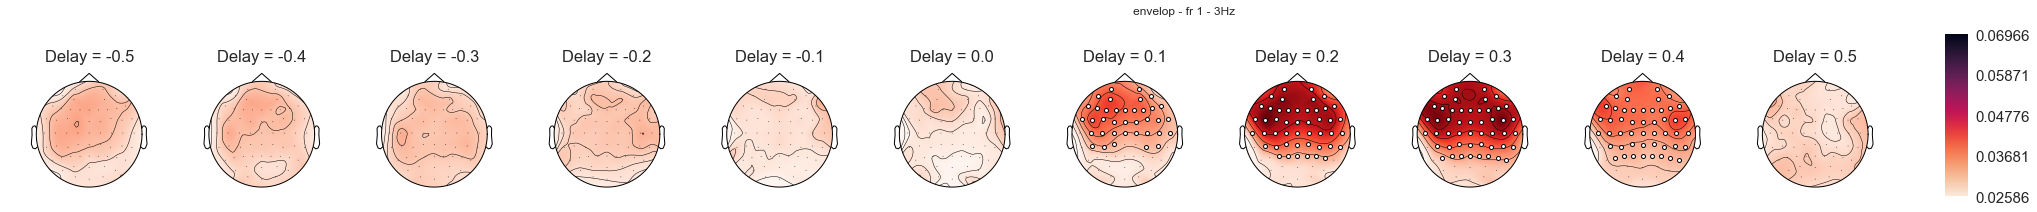

In [86]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['mask'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)


fg = sns.FacetGrid(sig_A, col='Delay', margin_titles=True)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(extra_channels[0]+' - '+freq_band[0])

cbar_ax = b.fig.add_axes([0.82,0.10,0.01,0.75])

#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax)

# Measure the coherence in specific delay and shifting the eeg and speech from speech onset (proxy for attention)

In [ ]:
trial_len = 2
remove_first = [0,0.1,0.2,0.3,0.4,0.5] #seconds
delay = [0]

freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['Normal']

save_path = data_path + '/data/coherence'
info = mne.io.read_raw_fif((save_path+'-info'),preload=True)
frame = []
for rf in remove_first:
    save_path = data_path + '/data/shift/coherence-trialLen-'+str(trial_len)+'-removedFirst-'+str(rf)+'s'
    a=[]
    for s in subject_name:
        a.append(pd.read_pickle(save_path+'-'+s))

    data = pd.concat((a),axis=0)
    #data['Delay']=data['Delay']
    data['Delay']=data['Delay'] - 0.5

    data['Delay']=data['Delay'].round(decimals=1)
    data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
    data.sort_index(inplace=True)
    a  = data['Data'].apply(lambda x: np.mean(x))
    data['Coherence'] = pd.Series(a, index=data.index)

    # plot coherence values according to time shift (remove_first)    

    AA = []
    for f in freq_band:
        a = data.loc[extra_channels,f,condition,delay,subject_name]['Coherence']
        a = data.loc[extra_channels,f,condition]['Coherence']
        a = pd.DataFrame(a.reset_index())
        a['Shift'] = rf
        AA.append(a)
        
    data=pd.concat((AA),axis=0)
    frame.append(data)
    
data=pd.concat((frame),axis=0)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)
data.sample(10)

for f in freq_band:
    #a = data.loc[extra_channels,f,condition,delay,subject_name]['Coherence']
    a = data.loc[extra_channels,f,condition,delay]
    a = pd.DataFrame(a.reset_index())
    
    fig, axes = plt.subplots(1, 1,figsize=(10,5))
    # Plot the response with standard error
    b=sns.tsplot(data=a, time="Shift", unit="Subject",condition="Feature", value="Coherence",ax=axes)
    b=b.set_title(f)

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['fr 1 - 3Hz','fr 4 - 6Hz']
#freq_band = ['fr 1 - 3Hz', 'fr 2 - 4Hz', 'fr 3 - 5Hz', 'fr 4 - 6Hz','fr 5 - 7Hz', 'fr 6 - 8Hz', 'fr 7 - 9Hz', 'fr 8 - 10Hz',
# 'fr 9 - 11Hz', 'fr 10 - 12Hz']

#freq_band = ['fr 3 - 5Hz']
extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop']

condition = ['Hyper','Normal','Hypo','All']
condition = ['All']
delay = np.arange(-5,6) / 10



for f in freq_band:
    A = []
    for feat in extra_channels:
        name = (feat,f)
        for d in delay:
            a = get_coherence_value(data,name,subject_name,d,condition)
            A.append(a)
    a = plot_coherence_preprocess_delay(A,name,condition,delay,info)
    


In [ ]:
freq_band = ('Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz')
freq_band = ['Delta 1 - 3Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
#extra_channels = ['lipaparature','jawaopening']

condition = ['Hyper','Normal','Hypo']
condition = ['All']

for f in freq_band:
    
    frames=[]
    frames_std=[]
    for feat in extra_channels:
        name = (feat,f)
        delay = np.arange(-5,6) / 10
        a,b = get_coherence_value_delay(data,name,subject_name,delay,condition)
        
        for c in condition:
            frames.append(pd.DataFrame({c+feat:a[c]}))
            frames_std.append(pd.DataFrame({c+feat:b[c]}))
            
    df=pd.concat((frames),axis=1)
    df_std=pd.concat((frames_std),axis=1)

    if(len(condition)!=1):
        fig, axes = plt.subplots(1, len(condition),figsize=(15,5))
    
    for c in range(0,len(condition)):
        a = df[[condition[c]+s for s in extra_channels]]
        b = df_std[[condition[c]+s for s in extra_channels]]

        if(len(condition)==1):
            ax = a.plot(grid=True,title=condition[c]+' '+name[1],figsize=(15,8))
        else:
            ax = a.plot(grid=True,title=condition[c]+' '+name[1],ax=axes[c])
        ax.set_ylabel('Coherence')
        #ax.fill_between(a.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.2)

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['jawaopening']

condition = ['Hyper','Normal','Hypo']
condition = ['All']

for feat in extra_channels:
    fig, axes = plt.subplots(1, 2,figsize=(15,5))
    for f in range(0,len(freq_band)):
        name = (feat,freq_band[f])
        delay = np.arange(-5,6) / 10
        a = get_coherence_value_delay(data,name,subject_name,delay,condition)
        ax=a.plot(grid=True,ax=axes[f],title=name[0]+' - '+name[1])
        ax= ax.set_ylabel('Coherence')

In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz']
freq_band = ['fr 1 - 3Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['Hyper','Normal','Hypo','All']
condition = ['Hyper']

delay = np.arange(-5,6) / 10

for f in freq_band:
    a = data.loc[extra_channels,f,condition,delay,subject_name]['Coherence']
    a = pd.DataFrame(a.reset_index())

    fig, axes = plt.subplots(1, 1,figsize=(15,8))
    # Plot the response with standard error
    b=sns.tsplot(data=a, time="Delay", unit="Subject",condition="Feature", value="Coherence",ax=axes)
    b=b.set_title(f)


In [ ]:
freq_band = ['Delta 1 - 3Hz','Theta 4 - 7Hz','Alpha 8 - 12Hz','Beta 13 - 25Hz','Gamma 30 - 40Hz']
freq_band = ['Delta 1 - 3Hz']

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop']

condition = ['Hyper','Normal','Hypo']

for f in freq_band:
    for feat in extra_channels:
        name = (feat,f)
        delay = 0.1
        a = get_coherence_value(data,name,subject_name,delay,condition)
        plot_coherence_preprocess(a,name,condition,delay,info)

In [ ]:
Hyper  = data.loc['envelop','Theta 4 - 7Hz','Hyper',0.3,subject_name]
Hyper['Data'].mean()